# Imports

In [1]:
import pandas as pd

from ForecastEvaluator import ForecastEvaluator
from _config import PATH_TO_CONFIG
from data_loader import MyDataLoader
from my_config import load_config, MyConfig

# Load (Preprocessed Step 1) DTU Solar Station data

In [2]:
my_config: MyConfig = load_config(PATH_TO_CONFIG)
data_loader = MyDataLoader(my_config)
data_loader.load_data()
data_loader.reindex_full_range()
data_loader.lag_features()
data_loader.prepare_df(drop_solar_altitude_below_0=False, drop_nan=False)
df = data_loader.get_df()

mask = df.isna().values
# make all nan values zero
df.fillna(0, inplace=True)
display(df.head())

# mask = df.isna().values
# # make all nan values zero
# df.fillna(0, inplace=True)

display(df.head())

,DNI,DNI_lag_60,DNI_lag_1440,DNI_lag_2880
2015-03-12 05:36:00,0.000000,0.0,0.0,0.0
2015-03-12 05:37:00,0.000000,0.0,0.0,0.0
2015-03-12 05:38:00,0.814740,0.0,0.0,0.0
2015-03-12 05:39:00,26.392772,0.0,0.0,0.0
2015-03-12 05:40:00,61.929423,0.0,0.0,0.0


,DNI,DNI_lag_60,DNI_lag_1440,DNI_lag_2880
2015-03-12 05:36:00,0.000000,0.0,0.0,0.0
2015-03-12 05:37:00,0.000000,0.0,0.0,0.0
2015-03-12 05:38:00,0.814740,0.0,0.0,0.0
2015-03-12 05:39:00,26.392772,0.0,0.0,0.0
2015-03-12 05:40:00,61.929423,0.0,0.0,0.0


# ARIMA model

In [3]:
import statsmodels.api as sm
model = sm.OLS(df[data_loader.get_target_names()], df[data_loader.get_feature_names()], missing='drop')
res_ols = model.fit()

print(res_ols.summary())
# res_ols.params['y_lag60'] is your φ60


                                 OLS Regression Results                                
Dep. Variable:                    DNI   R-squared (uncentered):                   0.677
Model:                            OLS   Adj. R-squared (uncentered):              0.677
Method:                 Least Squares   F-statistic:                          3.599e+06
Date:                Mon, 26 May 2025   Prob (F-statistic):                        0.00
Time:                        14:18:00   Log-Likelihood:                     -3.3472e+07
No. Observations:             5159669   AIC:                                  6.694e+07
Df Residuals:                 5159666   BIC:                                  6.694e+07
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

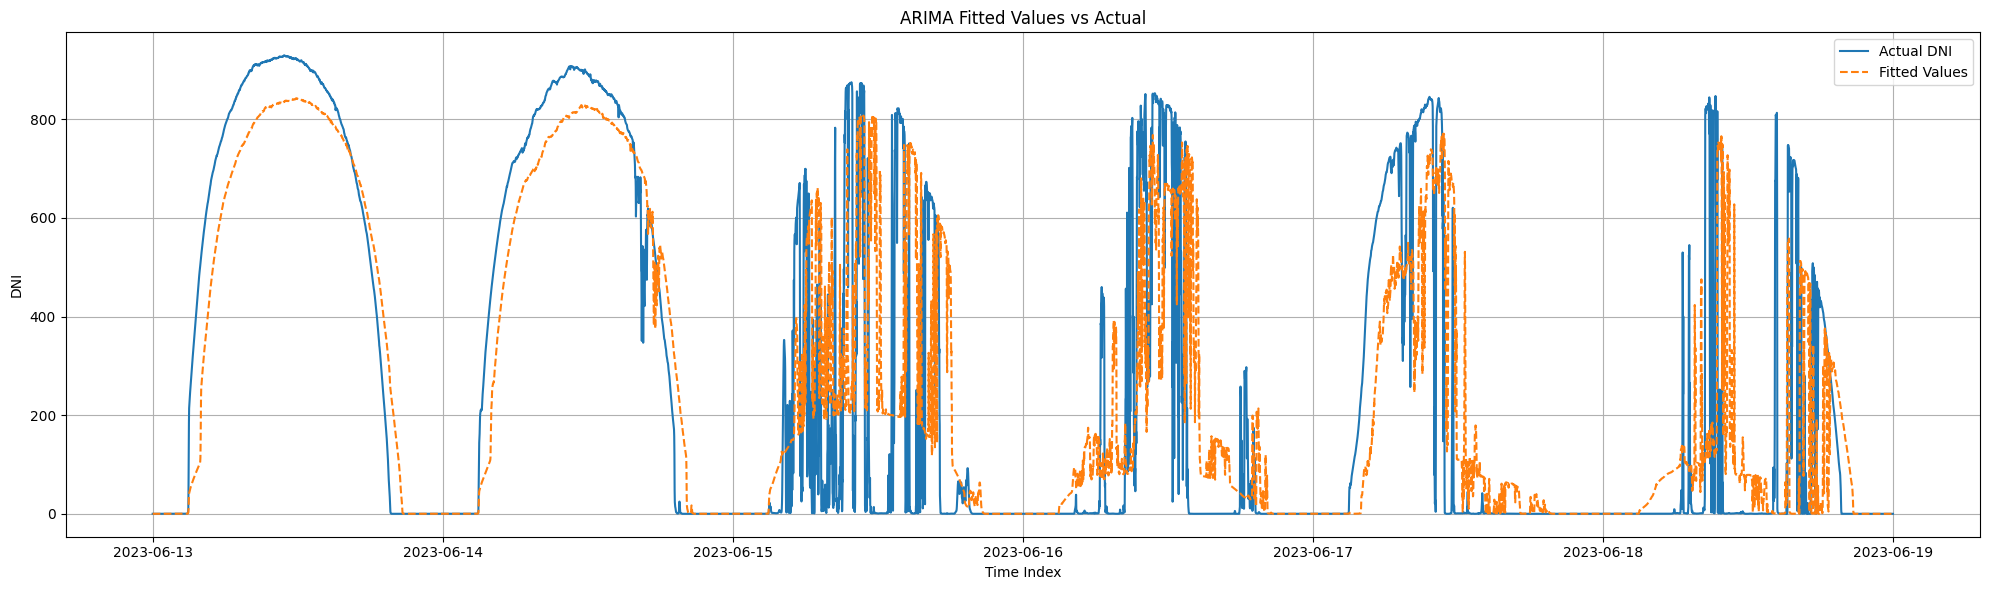

In [4]:
start = '2023-06-13'
end = '2023-06-18'
fitted_values = res_ols.fittedvalues
# Plot fitted values
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 6))
plt.plot(df.loc[start:end].index, df.loc[start:end]['DNI'], label='Actual DNI')
plt.plot(df.loc[start:end].index, fitted_values.loc[start:end], label='Fitted Values', linestyle='--')
plt.title('ARIMA Fitted Values vs Actual')
plt.xlabel('Time Index')
plt.ylabel('DNI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
fitted_values

2015-03-12 05:36:00    0.0
2015-03-12 05:37:00    0.0
2015-03-12 05:38:00    0.0
2015-03-12 05:39:00    0.0
2015-03-12 05:40:00    0.0
                      ... 
2025-01-01 08:00:00    0.0
2025-01-01 08:01:00    0.0
2025-01-01 08:02:00    0.0
2025-01-01 08:03:00    0.0
2025-01-01 08:04:00    0.0
Freq: min, Length: 5159669, dtype: float64

In [6]:
from data_loader import SPLIT
fitted_values.loc[data_loader.get_split(SPLIT.TEST).index]

2023-01-01 00:00:00    0.0
2023-01-01 00:01:00    0.0
2023-01-01 00:02:00    0.0
2023-01-01 00:03:00    0.0
2023-01-01 00:04:00    0.0
                      ... 
2024-12-30 23:56:00    0.0
2024-12-30 23:57:00    0.0
2024-12-30 23:58:00    0.0
2024-12-30 23:59:00    0.0
2024-12-31 00:00:00    0.0
Freq: min, Length: 1051201, dtype: float64

In [11]:
test_predictions_df = pd.DataFrame({
    'Actual': df.loc[data_loader.get_split(SPLIT.TEST).index, 'DNI'],
    'Predicted': fitted_values.loc[data_loader.get_split(SPLIT.TEST).index]
})

test_predictions_df.to_pickle('OLS_performance_predictions_df.pkl')
test_predictions_df.to_csv('OLS_performance_predictions_df.csv')
test_predictions_df


,Actual,Predicted
2023-01-01 00:00:00,0.0,0.0
2023-01-01 00:01:00,0.0,0.0
2023-01-01 00:02:00,0.0,0.0
2023-01-01 00:03:00,0.0,0.0
2023-01-01 00:04:00,0.0,0.0
...,...,...
2024-12-30 23:56:00,0.0,0.0
2024-12-30 23:57:00,0.0,0.0
2024-12-30 23:58:00,0.0,0.0
2024-12-30 23:59:00,0.0,0.0


In [9]:
from ForecastEvaluator import ForecastEvaluator
ForecastEvaluator(
    y_true=test_predictions_df['Actual'],
    y_pred=test_predictions_df['Predicted'],
).evaluate_all()

{'RMSE': np.float64(156.15546651503115),
 'MAE': 71.4447255506461,
 'MAPE': np.float64(28759.37747745426),
 'R2': 0.6332924455926879,
 'NMAE': np.float64(0.07158317855509327),
 'NRMSE': np.float64(0.15645808078547904),
 'Skill Score': 0.633292445592688,
 'MBE': np.float64(-10.522232055442467)}

KeyError: 'Actual'